# 

# Predictions

## Post-training analysis

### Training dataset

Loading the training dataset and keeping aside the column for real outcome.

In [4]:
import matplotlib as plt
import numpy as np
import pandas as pd
import seaborn as sns

filepath = f'../datasets/dataset_train.csv'
df = pd.read_csv(filepath)
target = 'Hogwarts House'
df_real_class = df[target]
df_real_class.head()

0     Ravenclaw
1     Slytherin
2     Ravenclaw
3    Gryffindor
4    Gryffindor
Name: Hogwarts House, dtype: object

Loading weights - from the last training.
model_features : 
    Features used for training, after removing the intercept label

In [5]:
model_weights = pd.read_csv(f'../logistic_reg_model/gradient_descent_weights.csv')
# model_weights.drop(columns="Unnamed: 0", inplace=True)
features_label = model_weights.columns[0]
model_features = model_weights[features_label].to_list()[1:]
model_weights.head(10)

,Unnamed: 0,Ravenclaw,Slytherin,Gryffindor,Hufflepuff
0,Intercept,-2.063288,-3.078807,-2.552069,-1.838883
1,Astronomy,-0.624465,-0.670321,0.744304,2.293351
2,Herbology,0.251859,-1.008757,-1.105949,1.199094
3,Divination,-0.124170,-1.983393,0.207335,0.582858
4,Muggle Studies,1.659259,-0.162888,0.083594,-0.767951
5,Ancient Runes,1.302604,-0.275861,1.209321,-1.223023
6,History of Magic,0.456211,0.376363,-0.460563,1.317606
7,Transfiguration,0.740783,0.885958,-0.592183,1.134559
8,Potions,-0.037471,0.619222,0.034073,-0.453751
9,Charms,0.960865,-0.606215,-0.472536,-0.396028


Dataset for testing - keeping only useful features

In [6]:
df_test = df[model_features]
df_test.head()

,Astronomy,Herbology,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Charms,Flying
0,-487.886086,5.727180,4.722,272.035831,532.484226,5.231058,1039.788281,3.790369,-232.79405,-26.89
1,-552.060507,-5.987446,-5.612,-487.340557,367.760303,4.107170,1058.944592,7.248742,-252.18425,-113.45
2,-366.076117,7.725017,6.140,664.893521,602.585284,3.555579,1088.088348,8.728531,-227.34265,30.42
3,697.742809,-6.497214,4.026,-537.001128,523.982133,-4.809637,920.391449,0.821911,-256.84675,200.64
4,436.775204,-7.820623,2.236,-444.262537,599.324514,-3.444377,937.434724,4.311066,-256.38730,157.98


Standardize (z-score method), replace NaNs with zeros (which is the mean after standardization)

In [7]:
def standardize(arr: np.ndarray):
    return (arr - np.mean(arr)) / np.std(arr)

df_test_std = df_test.agg(lambda feature: standardize(feature))
df_test_std.fillna(0, inplace=True)
df_test_std.shape

(1600, 10)

Preparing test dataset and weights for numpy dot product

In [8]:
x_test = np.array(df_test_std)
ones = np.ones((len(x_test), 1), dtype=float)
x_test = np.concatenate((ones, x_test), axis=1)
weights = np.array(model_weights.drop(columns=features_label))
print(x_test.dtype, x_test.shape)
print(weights.dtype, weights.shape)

float64 (1600, 11)
float64 (11, 4)


numpy dot product 

In [9]:
def sigmoid(arr:np.ndarray):
    return 1 / (1 + np.exp(-arr))

classifiers = model_weights.columns[1:].to_list()
z = np.dot(x_test, weights)
h = sigmoid(z)
y_pred_proba = pd.DataFrame(h, columns=classifiers)
y_pred_proba.head()


,Ravenclaw,Slytherin,Gryffindor,Hufflepuff
0,0.901828,0.005788,0.004045,0.030185
1,0.006846,0.993172,0.002023,0.011038
2,0.996975,0.005706,0.010602,0.022658
3,0.000823,0.004163,0.998306,0.023733
4,0.004757,0.038570,0.997453,0.001968


As a function that returns a DataFrame wth the probability

In [10]:
def sigmoid(arr:np.ndarray):
    return 1 / (1 + np.exp(-arr))

def predict_proba(df_test_std: pd.DataFrame, model_weights: pd.DataFrame) -> pd.DataFrame:
    x_test = np.array(df_test_std)
    ones = np.ones((len(x_test), 1), dtype=float)
    x_test = np.concatenate((ones, x_test), axis=1)
    weights = np.array(model_weights.drop(columns=features_label))
    classifiers = model_weights.columns[1:].to_list()
    z = np.dot(x_test, weights)
    h = sigmoid(z)
    y_pred_proba = pd.DataFrame(h, columns=classifiers)
    return y_pred_proba

y_pred_proba = predict_proba(df_test_std, model_weights)
y_pred_proba.head(10)

,Ravenclaw,Slytherin,Gryffindor,Hufflepuff
0,0.901828,0.005788,0.004045,0.030185
1,0.006846,0.993172,0.002023,0.011038
2,0.996975,0.005706,0.010602,0.022658
3,0.000823,0.004163,0.998306,0.023733
4,0.004757,0.038570,0.997453,0.001968
5,0.031094,0.997046,0.005343,0.004851
6,0.000542,0.005886,0.999608,0.011860
7,0.028189,0.026981,0.048574,0.907971
8,0.002572,0.001314,0.999077,0.007889
9,0.009835,0.006861,0.003048,0.995473


In [11]:
y_pred_proba['Probability'] = y_pred_proba.max(axis=1)

Heatmap of the Predicted output probability on a slice of dataset

<Axes: >

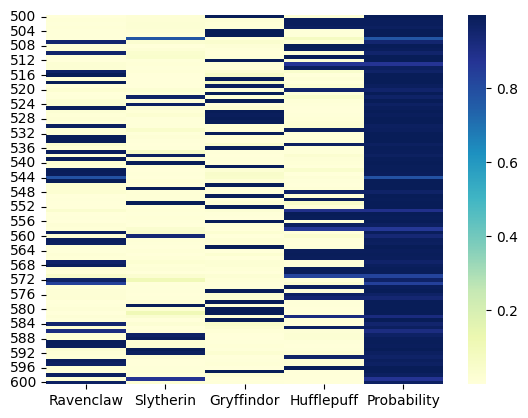

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

sns.heatmap(y_pred_proba.loc[500:600], cmap='YlGnBu')

Comparing real and predicted outcome


In [13]:
y_pred_proba['Predicted outcome'] = y_pred_proba.idxmax(axis=1)
y_pred_proba['Real outcome'] = df_real_class.to_list()
accurate_pred = np.where(y_pred_proba['Predicted outcome'] == y_pred_proba['Real outcome'], 1, 0)
y_pred_proba['Accurate pred.'] = accurate_pred
y_pred_proba.loc[500:510].head(10)

,Ravenclaw,Slytherin,Gryffindor,Hufflepuff,Probability,Predicted outcome,Real outcome,Accurate pred.
500,0.001918,0.012930,0.996695,0.009759,0.996695,Gryffindor,Gryffindor,1
501,0.010905,0.017344,0.018243,0.988220,0.988220,Hufflepuff,Hufflepuff,1
502,0.005297,0.021671,0.008782,0.989963,0.989963,Hufflepuff,Hufflepuff,1
503,0.009509,0.020686,0.010840,0.980935,0.980935,Hufflepuff,Hufflepuff,1
504,0.006697,0.015649,0.998317,0.005685,0.998317,Gryffindor,Ravenclaw,0
505,0.004476,0.005743,0.996873,0.007262,0.996873,Gryffindor,Gryffindor,1
506,0.007498,0.770265,0.003068,0.073149,0.770265,Slytherin,Slytherin,1
507,0.951180,0.031112,0.037322,0.016841,0.951180,Ravenclaw,Ravenclaw,1
508,0.005538,0.002959,0.015838,0.997086,0.997086,Hufflepuff,Hufflepuff,1
509,0.011970,0.012426,0.005715,0.988634,0.988634,Hufflepuff,Hufflepuff,1


Inexact prediction still have a high Probabilty

In [14]:
y_pred_proba[y_pred_proba['Accurate pred.'] == 0]

,Ravenclaw,Slytherin,Gryffindor,Hufflepuff,Probability,Predicted outcome,Real outcome,Accurate pred.
184,0.003383,0.996470,0.004485,0.013028,0.996470,Slytherin,Ravenclaw,0
200,0.011792,0.006476,0.014378,0.991491,0.991491,Hufflepuff,Ravenclaw,0
255,0.994860,0.006735,0.001783,0.153276,0.994860,Ravenclaw,Slytherin,0
339,0.011420,0.016845,0.026216,0.986717,0.986717,Hufflepuff,Ravenclaw,0
445,0.002651,0.019111,0.001848,0.995222,0.995222,Hufflepuff,Ravenclaw,0
456,0.977447,0.006256,0.019693,0.083703,0.977447,Ravenclaw,Slytherin,0
504,0.006697,0.015649,0.998317,0.005685,0.998317,Gryffindor,Ravenclaw,0
515,0.967331,0.009353,0.025406,0.041625,0.967331,Ravenclaw,Gryffindor,0
618,0.937586,0.117634,0.023615,0.008547,0.937586,Ravenclaw,Gryffindor,0
681,0.026447,0.977939,0.021618,0.004199,0.977939,Slytherin,Ravenclaw,0


In [15]:
(y_pred_proba['Accurate pred.'] == 1).value_counts()

Accurate pred.
True     1571
False      29
Name: count, dtype: int64

In [16]:
(y_pred_proba['Accurate pred.'].value_counts(1))

Accurate pred.
1    0.981875
0    0.018125
Name: proportion, dtype: float64

In [17]:
accuracy = (y_pred_proba['Accurate pred.'].value_counts(1))[1]
print(f'Accuracy for the training dataset: {accuracy * 100}%')

Accuracy for the training dataset: 98.1875%


### Testing dataset


In [19]:
filepath = f'../datasets/dataset_test.csv'
truthpath = f'../datasets/dataset_truth.csv'
df2 = pd.read_csv(filepath)
truth = pd.read_csv(truthpath)
target = 'Hogwarts House'
df_real_class = truth[target]
df_real_class.head()

0    Hufflepuff
1     Ravenclaw
2    Gryffindor
3    Hufflepuff
4    Hufflepuff
Name: Hogwarts House, dtype: object

In [20]:
df_test = df2[model_features]
df_test_std = df_test.agg(lambda feature: standardize(feature))
df_test_std.fillna(0, inplace=True)
df_test_std.shape

(400, 10)

In [21]:
def predict_proba(df_test_std: pd.DataFrame, model_weights: pd.DataFrame) -> pd.DataFrame:
    x_test = np.array(df_test_std)
    ones = np.ones((len(x_test), 1), dtype=float)
    x_test = np.concatenate((ones, x_test), axis=1)
    weights = np.array(model_weights.drop(columns=features_label))
    classifiers = model_weights.columns[1:].to_list()
    z = np.dot(x_test, weights)
    h = sigmoid(z)
    y_pred_proba = pd.DataFrame(h, columns=classifiers)
    return y_pred_proba

def sigmoid(arr:np.ndarray):
    return 1 / (1 + np.exp(-arr))

y_pred_proba = predict_proba(df_test_std, model_weights)
y_pred_proba.head(10)

,Ravenclaw,Slytherin,Gryffindor,Hufflepuff
0,0.009647,0.001993,0.019093,0.990774
1,0.981376,0.009838,0.016852,0.007702
2,0.003953,0.006670,0.998298,0.002103
3,0.017630,0.018416,0.011992,0.901193
4,0.012831,0.011944,0.008194,0.931399
5,0.004499,0.999266,0.001545,0.011183
6,0.985044,0.013196,0.054286,0.002123
7,0.007754,0.021138,0.022562,0.989873
8,0.988428,0.005108,0.028310,0.005175
9,0.030845,0.029281,0.014554,0.929889


<Axes: >

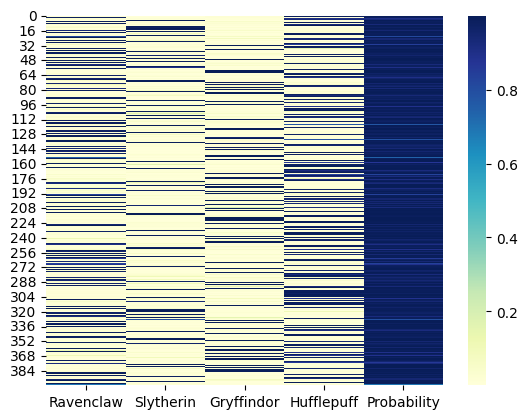

In [22]:
y_pred_proba['Probability'] = y_pred_proba.max(axis=1)
sns.heatmap(y_pred_proba.loc[:400], cmap='YlGnBu')


Is there probability < 0.5>

In [23]:
threshold = 0.5
y_pred_proba[y_pred_proba['Probability'] < threshold].count()

Ravenclaw      0
Slytherin      0
Gryffindor     0
Hufflepuff     0
Probability    0
dtype: int64

In [24]:
y_pred_proba['Predicted outcome'] = y_pred_proba.idxmax(axis=1)
y_pred_proba['Real outcome'] = df_real_class.to_list()
accurate_pred = np.where(y_pred_proba['Predicted outcome'] == y_pred_proba['Real outcome'], 1, 0)
y_pred_proba['Accurate pred.'] = accurate_pred
y_pred_proba.loc[100:150].head(20)

,Ravenclaw,Slytherin,Gryffindor,Hufflepuff,Probability,Predicted outcome,Real outcome,Accurate pred.
100,0.009451,0.011846,0.001851,0.988630,0.988630,Hufflepuff,Hufflepuff,1
101,0.064524,0.015555,0.011489,0.975158,0.975158,Hufflepuff,Hufflepuff,1
102,0.011722,0.010335,0.006181,0.991459,0.991459,Hufflepuff,Hufflepuff,1
103,0.007944,0.989377,0.013620,0.071365,0.989377,Slytherin,Slytherin,1
104,0.960321,0.066498,0.014897,0.002809,0.960321,Ravenclaw,Ravenclaw,1
105,0.985716,0.159061,0.047481,0.000349,0.985716,Ravenclaw,Ravenclaw,1
106,0.013906,0.044448,0.007553,0.972218,0.972218,Hufflepuff,Hufflepuff,1
107,0.021518,0.606516,0.007473,0.018131,0.606516,Slytherin,Slytherin,1
108,0.006486,0.999760,0.001182,0.005078,0.999760,Slytherin,Slytherin,1
109,0.033296,0.018715,0.048110,0.948347,0.948347,Hufflepuff,Hufflepuff,1


Inexact prediction:

In [25]:
inexact = y_pred_proba[y_pred_proba['Accurate pred.'] == 0]
inexact

,Ravenclaw,Slytherin,Gryffindor,Hufflepuff,Probability,Predicted outcome,Real outcome,Accurate pred.
23,0.996810,0.016360,0.007870,0.001339,0.996810,Ravenclaw,Slytherin,0
98,0.047736,0.030166,0.001681,0.893510,0.893510,Hufflepuff,Ravenclaw,0
279,0.004798,0.018699,0.008492,0.991952,0.991952,Hufflepuff,Slytherin,0
365,0.014180,0.001087,0.996863,0.005782,0.996863,Gryffindor,Slytherin,0


Getting students description with the index

In [26]:
df2.iloc[inexact.index.to_list()]

,Index,Hogwarts House,First Name,Last Name,Birthday,Best Hand,Arithmancy,Astronomy,Herbology,Defense Against the Dark Arts,Divination,Muggle Studies,Ancient Runes,History of Magic,Transfiguration,Potions,Care of Magical Creatures,Charms,Flying
23,23,NaN,Allan,Mcdade,2001-03-20,Left,74358.0,-577.375308,3.409038,5.773753,5.177,804.435862,640.245804,5.218387,1066.551493,7.347293,-0.941412,-230.77467,-62.86
98,98,NaN,Dara,Doty,1997-07-05,Right,38819.0,NaN,5.405685,NaN,3.787,-241.397110,383.495021,8.980822,1026.377378,5.809116,0.166099,-242.18932,-31.48
279,279,NaN,Sandy,Khan,2001-08-02,Left,NaN,626.121534,1.645414,-6.261215,7.233,-704.306597,408.066513,5.611332,1074.628148,7.465978,-1.719821,-245.89146,-52.96
365,365,NaN,Lillie,Gladden,1997-07-21,Left,51258.0,359.317235,-3.688339,-3.593172,7.040,-545.904202,614.272334,-5.750566,957.111185,1.507102,1.057626,-249.47558,192.69


In [27]:
(y_pred_proba['Accurate pred.'].value_counts(1))

Accurate pred.
1    0.99
0    0.01
Name: proportion, dtype: float64

In [28]:
accuracy = (y_pred_proba['Accurate pred.'].value_counts(1))[1]
print(f'Accuracy for the testing dataset: {accuracy * 100}%')

Accuracy for the testing dataset: 99.0%


### Results for testing dataset :

Accuracy: 99.0%   
excluded_features : "Arithmancy", "Defense Against the Dark Arts", "Care of Magical Creatures"
learning_rate = 0.1
epochs=1000

### Improvements

#### Decision Boundary:
Classification of our features by selecting probabilities above 0.5
If hθ(x) ≥ 0.5 → y=1 and If hθ(x) < 0.5 → y=0

In [ ]:
threshold = 0.5
y_pred_proba = predict_proba(df_test_std, model_weights)
above_threshold = (y_pred_proba.max(axis=1) >= threshold)
(above_threshold.value_counts(1))

: 

: 

: 